<center><h2> Walmart Sales Forecasting </h2></center>

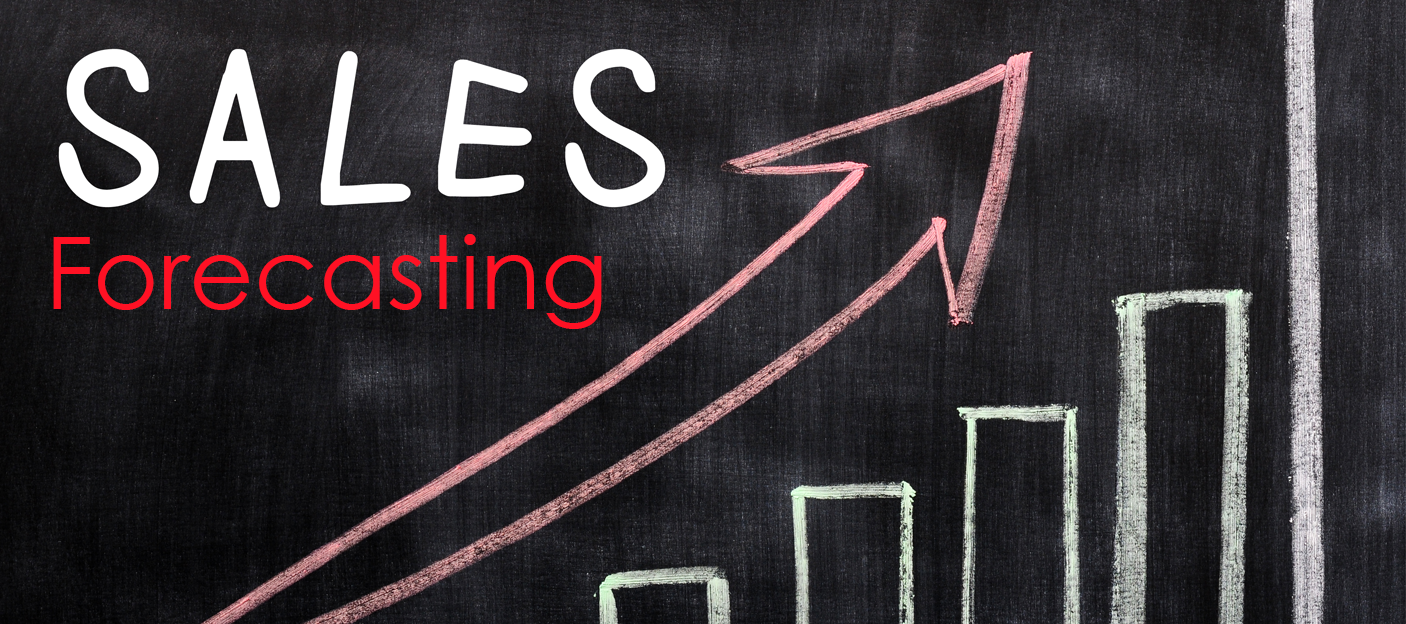

### Business Problem

이 프로젝트에서 서로 다른 지역에 위치한 45 개의 Walmart 매장에 대한 과거 판매 데이터를 제공받습니다. 각 상점에는 많은 부서가 있으며, 각 상점의 각 부서에 대한 매출을 예측 해야합니다.

### Data

또한 월마트는 연중 몇 가지 프로모션 인하 이벤트(markdown events)를 운영합니다. 이러한 인하는 눈에 띄는 명절을 앞두고 슈퍼 볼, 노동절, 추수 감사절, 크리스마스가 가장 큰 네 가지 명절입니다. 이러한 공휴일을 포함하는주는 평가에서 비 공휴일보다 5 배 더 가중치가 높습니다.

### Problem Statemtent

이러한 데이터를 사용하여 다양한 매개 변수를 기반으로 월마트 판매 예측을 예측해야합니다.

### Data Description

stores.csv

    이 파일에는 상점의 유형과 크기를 나타내는 45 개의 상점에 대한 익명 정보가 포함되어 있습니다.
 
train.csv

    이것은 2010-02-05에서 2012-11-01까지 포함되는 과거 훈련 데이터입니다. 이 파일에는 다음 필드가 있습니다.
     
    Store - the store number
    Dept - the department number
    Date - the week
    Weekly_Sales -  sales for the given department in the given store
    IsHoliday - whether the week is a special holiday week
    test.csv

이 파일은 우리가 주간 판매를 보류 한 것을 제외하고 train.csv와 동일합니다. 이 파일에서 각 세 개의 상점, 부서 및 날짜에 대한 매출을 예측해야합니다.
 

features.csv

    이 파일에는 지정된 날짜의 상점, 부서 및 지역 활동과 관련된 추가 데이터가 포함되어 있습니다. 다음 필드를 포함합니다.
     

    Store - the store number
    Date - the week
    Temperature - average temperature in the region
    Fuel_Price - cost of fuel in the region
    MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
    CPI - the consumer price index
    Unemployment - the unemployment rate
    IsHoliday - whether the week is a special holiday week

편의상 4 개의 휴일은 데이터 세트에서 다음 주에 속합니다 (모든 휴일이 데이터에있는 것은 아님).
 
 
Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot

from sklearn.model_selection import train_test_split

# 검증을 위한 라이브러리

from math import sqrt
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

# 모델 셀렉션

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import warnings

### Reading the Data From the CSV file

In [2]:
train_df = pd.read_csv('train.csv')
features_df = pd.read_csv('features.csv')
stores_df = pd.read_csv('stores.csv')
test_df = pd.read_csv('test.csv')



In [10]:
train_df
features_df
stores_df
test_df

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False
...,...,...,...,...
115059,45,98,2013-06-28,False
115060,45,98,2013-07-05,False
115061,45,98,2013-07-12,False
115062,45,98,2013-07-19,False


In [7]:
def scatter(train_merge, column):
    plt.figure()
    plt.scatter(train_merge[column] , train_merge['Weekly_Sales'])
    plt.ylabel('Weekly_Sales')
    plt.xlabel(column)

In [4]:
scatter(train_merge, 'Fuel_Price')  # with respect to Fuel_Price
scatter(train_merge, 'Size')  # with respect to Size
scatter(train_merge, 'CPI')  # with respect to CPI
scatter(train_merge, 'Type')  # with respect to Type
scatter(train_merge, 'IsHoliday') # with respect to IsHoliday
scatter(train_merge, 'Unemployment')  # with respect to Unemployment
scatter(train_merge, 'Temperature') # with respect to Temperature
scatter(train_merge, 'Store') # with respect to Store
scatter(train_merge, 'Dept')  # with respect to Dept

NameError: name 'train_merge' is not defined

### Correlation Matrix

연간 평균 주간 판매량을 살펴보고 'IsHoliday'에서 고려하지 않은 다른 휴일 최고 판매가 있는지 알아 보겠습니다.

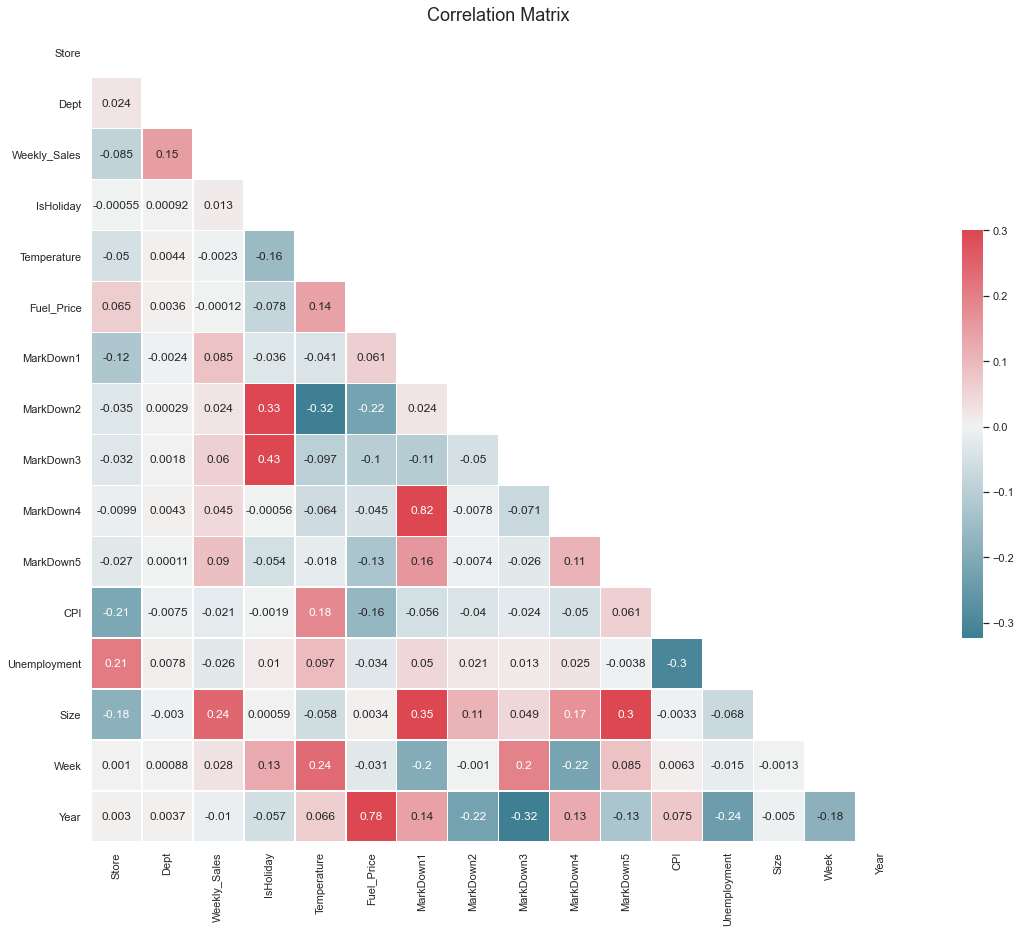

In [156]:
sns.set(style = "white")

corr = train_merge.corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(20, 15))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.title('Correlation Matrix', fontsize=18)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

In [157]:
# Dropping down the variables that have weak correlation

# 상관 관계가 약한 변수 삭제

train_merge = train_merge.drop(columns=['Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'])
test_merge = test_merge.drop(columns=['Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'])

### Dividing the data into Train and Test

# Model Building